In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os

In [76]:
# per file
data = []
with open("studies/study_2025-03-11_11-46-28/study_details.json") as f:
    data = list(json.load(f).values())        

In [71]:
# aggregate all files
data = []
for fn in os.listdir('.'):
    if fn.startswith('checkpoints_study_'):
        study_path = os.path.join(fn, "study_details.json")
        if os.path.exists(study_path):
            with open(study_path) as f:
                data.extend(list(json.load(f).values()))

In [77]:
hyperparam_data = []
exclude_keys = ["checkpoint_path", "trainable_parameters"]

for val in data:
    for k in exclude_keys:
        if k in val:
            val.pop(k)
            
    if "best_val_accuracy" in val and val["best_val_accuracy"] and type(val["best_val_accuracy"]) == list:
        val["best_val_accuracy"] = val["best_val_accuracy"][0]
    hyperparam_data.append(val)

In [78]:
# Create DataFrame
df = pd.DataFrame(hyperparam_data)
df

,model_type,batch_size,optimizer_type,learning_rate,momentum,weight_decay,scheduler_type,factor,patience,best_val_accuracy,eta_min,beta1,beta2
0,largeresnet,256,SGD,0.002144,0.912942,0.000072,ReduceLROnPlateau,0.314823,10.0,84.36,NaN,NaN,NaN
1,smallresnet,64,SGD,0.001432,0.953939,0.000245,OneCycleLR,0.170290,NaN,92.94,NaN,NaN,NaN
2,largeresnet,128,SGD,0.001217,0.935039,0.000398,OneCycleLR,0.036238,NaN,92.78,NaN,NaN,NaN
3,largeresnet,64,SGD,0.032485,0.944620,0.000264,CosineAnnealingLR,NaN,NaN,90.64,0.000007,NaN,NaN
4,efficientnet,64,SGD,0.063862,0.852150,0.000023,CosineAnnealingLR,NaN,NaN,90.26,0.000196,NaN,NaN
5,smallresnet,64,SGD,0.005982,0.912137,0.000037,CosineAnnealingLR,NaN,NaN,NaN,0.000088,NaN,NaN
6,efficientnet,128,AdamW,0.003191,NaN,0.002300,ReduceLROnPlateau,0.123125,8.0,NaN,NaN,0.947372,0.996185


In [79]:
# Plot hyperparameter vs validation accuracy
def plot_hyperparam_vs_acc(df, hyperparameter_column):
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=df, x=hyperparameter_column, y="best_val_accuracy")
    plt.title(f'{hyperparameter_column} vs Validation Accuracy')
    plt.xlabel(hyperparameter_column)
    plt.ylabel('Validation Accuracy')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.show()

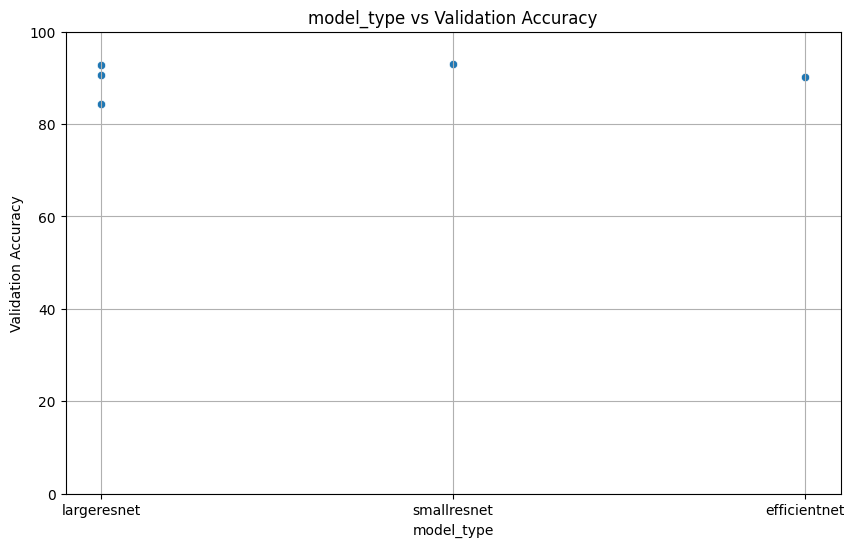

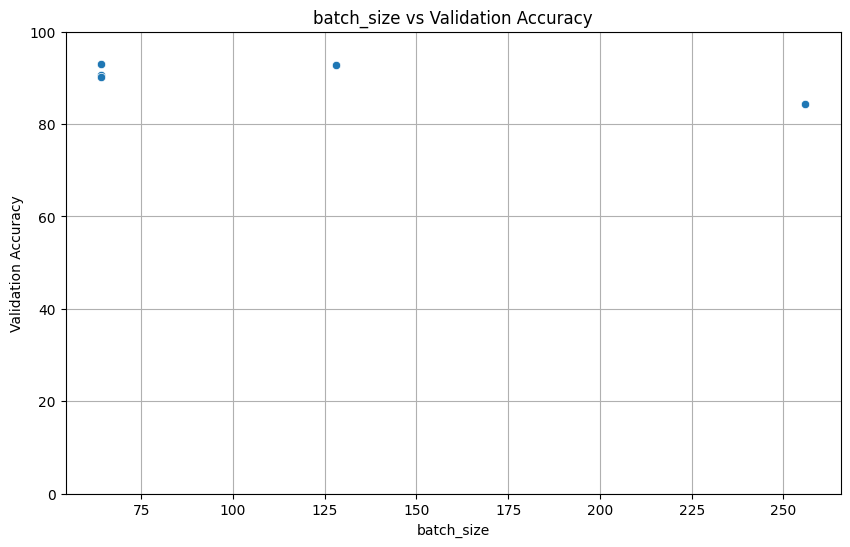

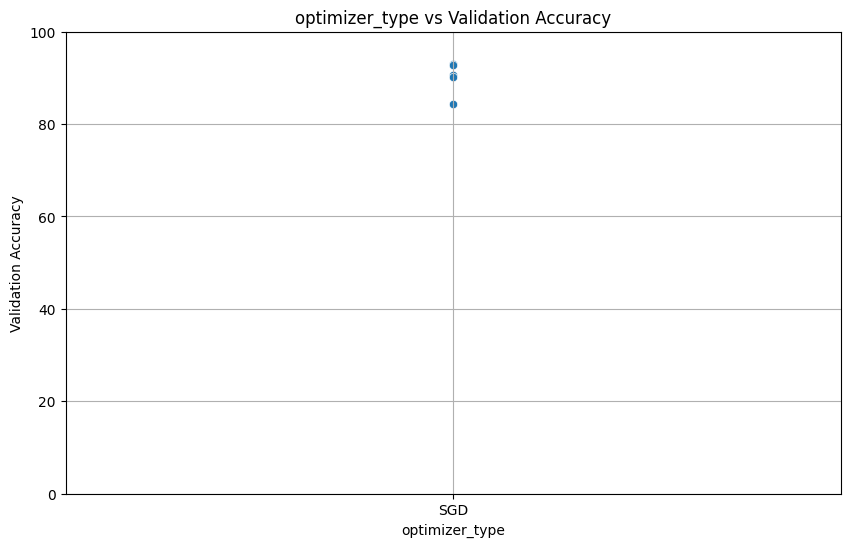

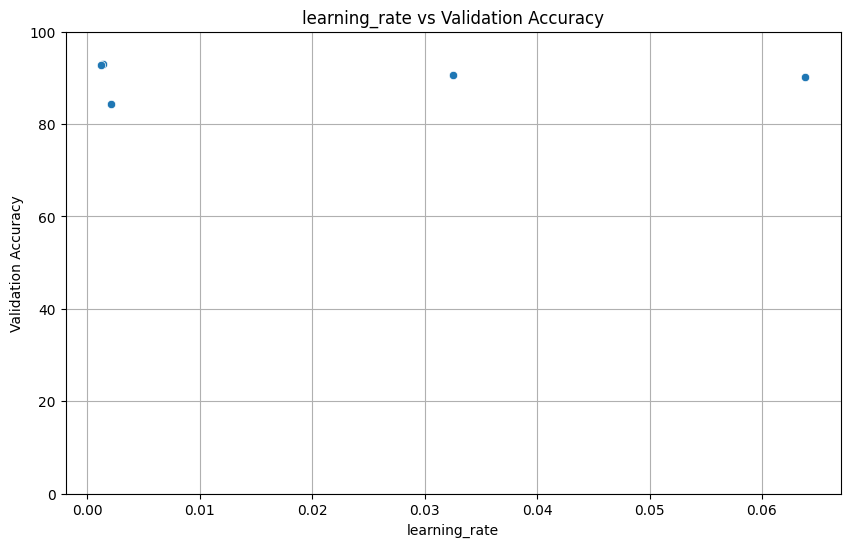

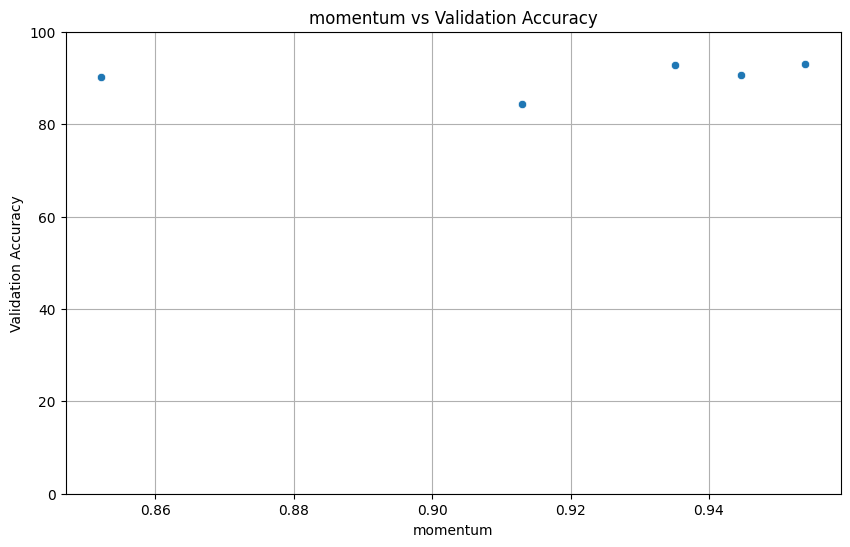

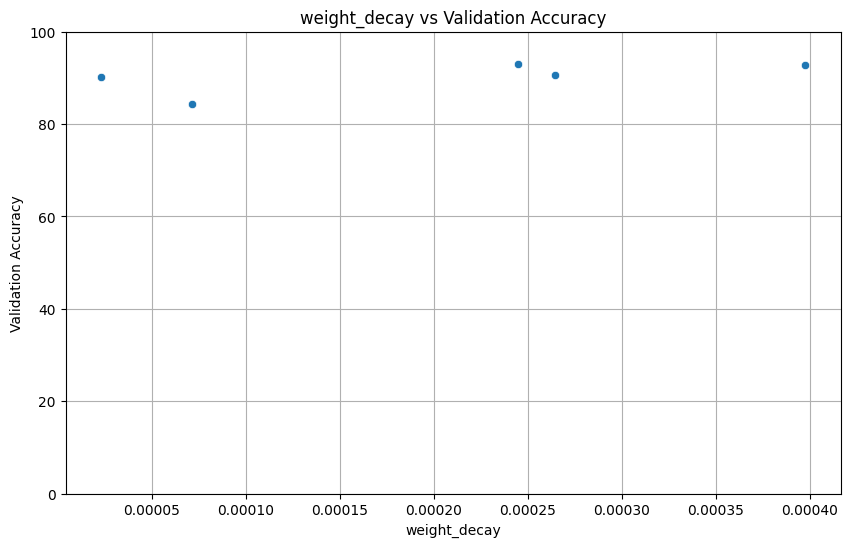

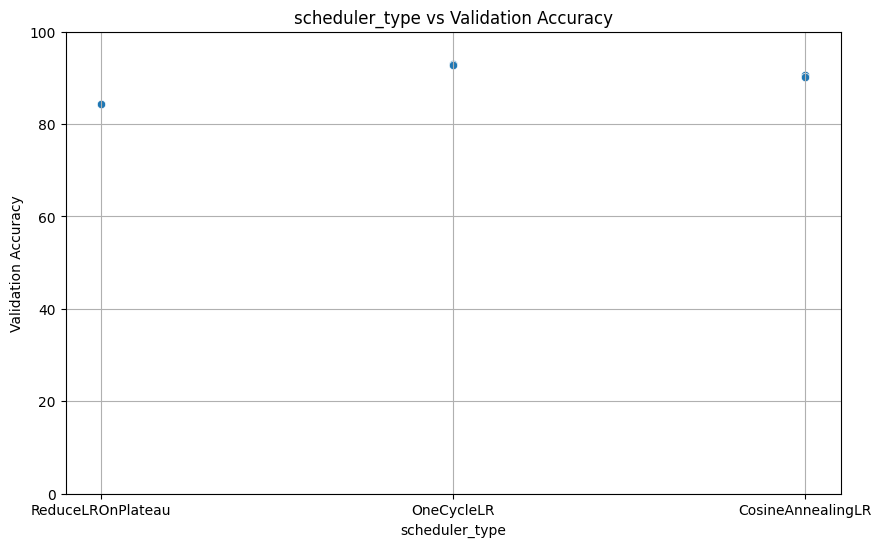

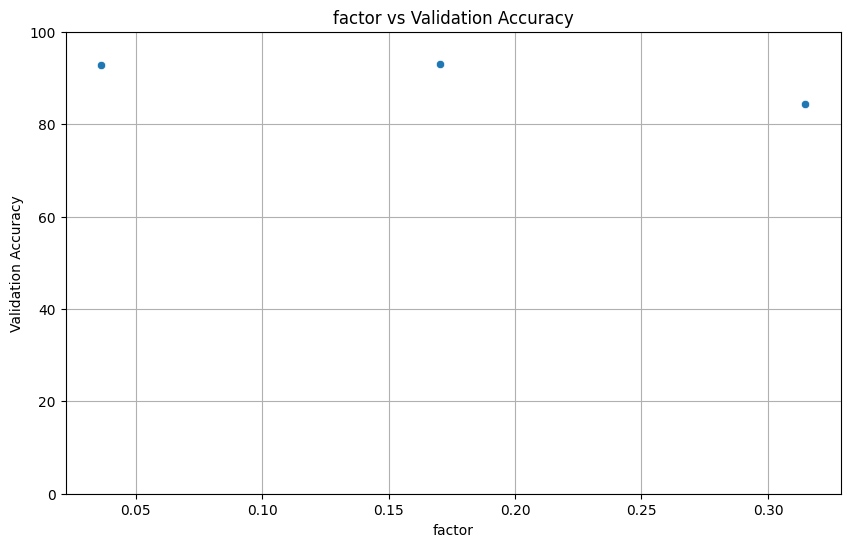

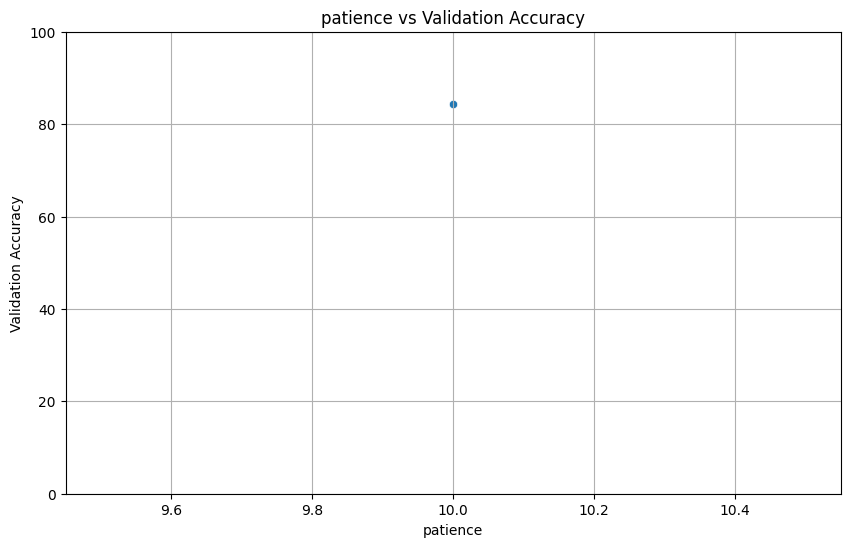

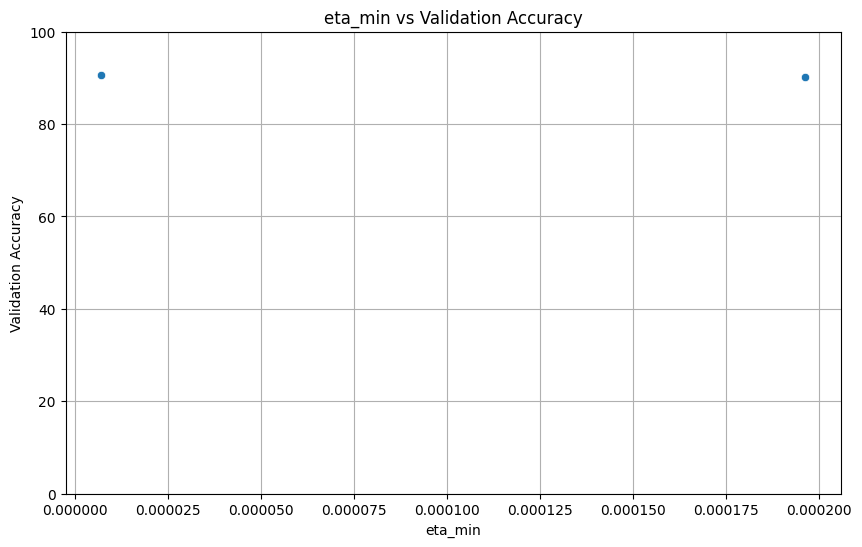

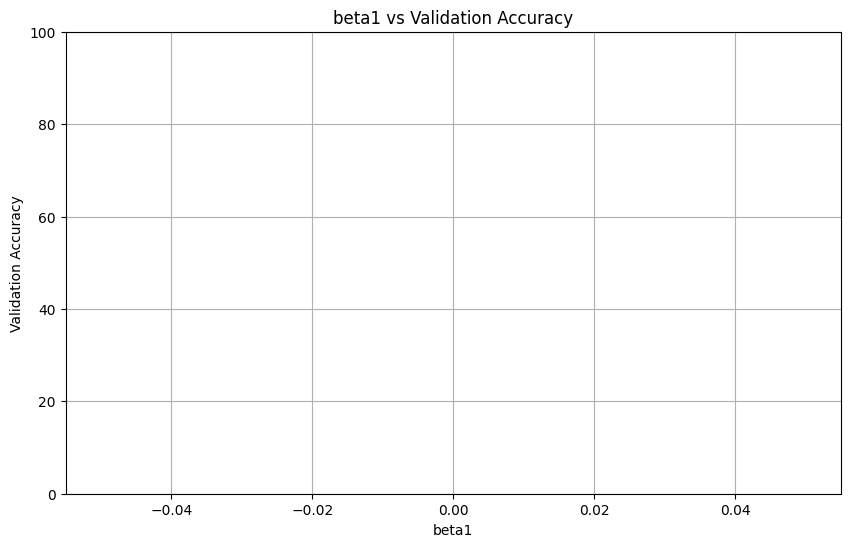

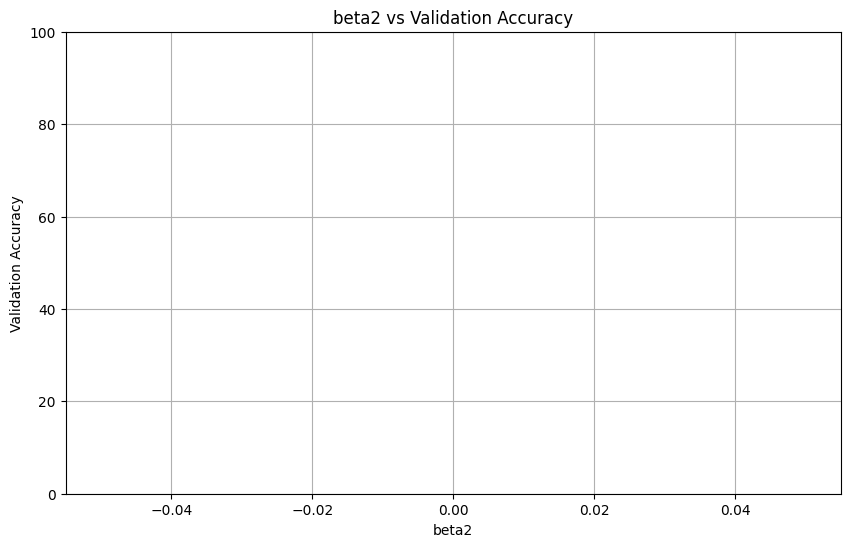

In [80]:
for param in df.columns.tolist():
    if param != "best_val_accuracy":
        plot_hyperparam_vs_acc(df, param)

In [104]:
%load_ext autoreload
%autoreload 2
import torch
from models import SmallResNet0, LargeResNet0, EfficientNetB0, BaseResNet
# from resnet_sc import SmallResNet
from trainer import evaluate_model
from data_loader import get_test_dataloader
from cifar10_1_dataloader import get_dataloader_10_1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = LargeResNet0()
# model = SmallResNet0()
model = BaseResNet()
model.to(device)

# best_checkpoint_fp = "studies/study_2025-03-11_11-46-28/checkpoint/trial_4_val_acc_ResNetLarge_90.6400_2025-03-11_13-45-32.pth"
# best_checkpoint_fp = "studies/study_2025-03-11_11-46-28/checkpoint/trial_2_val_acc_SmallResNet_92.9400_2025-03-11_12-58-46.pth"
# best_checkpoint_fp = "studies/study_2025-03-11_11-46-28/checkpoint/trial_3_val_acc_ResNetLarge_92.7800_2025-03-11_13-18-41.pth"
# best_checkpoint_fp = "studies/study_2025-03-11_01-51-41/checkpoint/trial_0_val_acc_SmallResNet_86.7000_2025-03-11_02-15-35.pth"
# best_checkpoint_fp = "checkpoints/val_acc_SmallResNet_89.5000_2025-03-11_16-09-39.pth"
# best_checkpoint_fp = "studies/study_2025-03-11_16-30-52/checkpoint/trial_0_val_acc_ResNetLarge_93.6400_2025-03-11_16-54-18.pth"
# best_checkpoint_fp = "studies/study_2025-03-11_16-30-52/checkpoint/trial_0_val_acc_ResNetLarge_93.6400_2025-03-11_16-54-18.pth"
best_checkpoint_fp = "studies/study_2025-03-11_21-11-23/checkpoint/trial_1_val_acc_ResNet_93.5000_2025-03-11_21-42-21.pth"

if not best_checkpoint_fp:
    checkpoint_dir = f"checkpoints_{study_name}"
    with open(os.path.join(checkpoint_dir, "study_details.json"), "r") as f:
        study_details = json.load(f)
    best_checkpoint_fp = study_details[str(study.best_trial.number)]["checkpoint_path"]

# Load the latest checkpoint
checkpoint = torch.load(best_checkpoint_fp)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [111]:
test_loader = get_test_dataloader(grayscale=False, use_kaggle=True)
acc, _ = evaluate_model(model, test_loader, device=device)
print("test Acc:", acc)

test Acc: 93.94


In [107]:
dataloader_10_1 = get_dataloader_10_1(num_samples=2000)
acc, _ = evaluate_model(model, dataloader_10_1, device)
print("cidar10.1 Acc:", acc)

cidar10.1 Acc: 86.4


### Run model on Kaggle test data

In [60]:
from data_loader import get_kaggle_test_dataloader
import pandas as pd
import numpy as np

In [61]:
# Generate submission file with test data
kaggle_test_loader = get_kaggle_test_dataloader()

model.eval()
predictions = []

with torch.no_grad():
    for images, in kaggle_test_loader:
        images = images.to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('submission.csv', index=False)
print("submission file saved.")

submission file saved.


In [62]:
# import kaggle
# kaggle.api.competition_submit(
#     file_name="submission.csv",
#     message="93.3%",
#     competition="deep-learning-spring-2025-project-1"
# )

100%|██████████| 67.3k/67.3k [00:00<00:00, 337kB/s]


Successfully submitted to Deep Learning Spring 2025: CIFAR 10 classification

### pseudo labels

In [100]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

def generate_pseudo_labels(model, test_loader, conf_threshold=0.9, device="cuda"):
    """ Generate pseudo-labels for high-confidence test samples """
    model.eval()
    pseudo_data, pseudo_labels = [], []

    with torch.no_grad():
        for images, _ in test_loader:  # Unlabeled test data
            images = images.to(device)
            outputs = torch.softmax(model(images), dim=1)  # Get probabilities
            max_probs, preds = torch.max(outputs, dim=1)  # Get confidence & predicted class
            
            # Keep only high-confidence predictions
            mask = max_probs > conf_threshold
            if mask.sum().item() > 0:  # If any samples meet the confidence threshold
                pseudo_data.append(images[mask])
                pseudo_labels.append(preds[mask])

    if pseudo_data:
        pseudo_data = torch.cat(pseudo_data)
        pseudo_labels = torch.cat(pseudo_labels)
    else:
        pseudo_data, pseudo_labels = None, None  # No confident samples found

    return pseudo_data, pseudo_labels

In [103]:
def add_pseudo_labels_to_training(train_loader, pseudo_data, pseudo_labels, batch_size=128):
    """ Add pseudo-labeled data to training set """
    if pseudo_data is not None:
        pseudo_dataset = TensorDataset(pseudo_data, pseudo_labels)
        combined_dataset = torch.utils.data.ConcatDataset([train_loader.dataset, pseudo_dataset])
        new_train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
        return new_train_loader
    else:
        return train_loader  # No pseudo-labels, return original train loader

In [ ]:
# Generate pseudo-labels from test set
pseudo_x, pseudo_y = generate_pseudo_labels(model, test_loader, conf_threshold=0.9)

# Create new training set with pseudo-labels
new_train_loader = add_pseudo_labels_to_training(train_loader, pseudo_x, pseudo_y)

# Fine-tune model
for epoch in range(5):  # Fine-tune for a few epochs
    train_one_epoch(model, new_train_loader, optimizer)

### TTA - Only on low confidence predictions

In [109]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Define mild TTA augmentations
tta_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(degrees=5),
]

def tta_predict_batched(model, images, device="cuda", conf_threshold=0.8):
    """ Apply TTA only for low-confidence predictions """
    model.eval()
    images = images.to(device)  # Move batch to GPU

    # Get original prediction
    with torch.no_grad():
        orig_logits = model(images)  # Get logits
        orig_pred = F.softmax(orig_logits, dim=-1)  # Convert to probabilities
        orig_conf, orig_class = torch.max(orig_pred, dim=1)  # Confidence & predicted class

    # Identify low-confidence samples
    low_conf_mask = orig_conf < conf_threshold  # Boolean mask for uncertain predictions

    # ✅ FIX: Ensure TTA is skipped when threshold is too low
    if low_conf_mask.sum().item() == 0:
        return orig_pred  # Skip TTA and return original predictions

    # Select only uncertain images for TTA
    uncertain_images = images[low_conf_mask]

    # Generate augmentations
    batch_augmented = [uncertain_images]  # Start with original uncertain images
    for t in tta_transforms:
        batch_augmented.append(t(uncertain_images))  # Apply TTA

    # Stack augmented images: [TTA * Uncertain_B, C, H, W]
    batch_augmented = torch.cat(batch_augmented, dim=0)

    # Run inference for TTA batch
    with torch.no_grad():
        preds = model(batch_augmented)  # Get logits (not softmax)

    # Reshape: [TTA, Uncertain_B, num_classes]
    num_tta = len(tta_transforms) + 1  # +1 for original image
    preds = preds.view(num_tta, uncertain_images.size(0), -1)

    # Average logits over TTA versions
    final_tta_pred = torch.mean(preds, dim=0)  # [Uncertain_B, num_classes]
    final_tta_pred = F.softmax(final_tta_pred, dim=-1)  # Apply softmax at the end

    # Merge TTA predictions with original confident predictions
    final_pred = orig_pred.clone()  # Copy original predictions
    final_pred[low_conf_mask] = final_tta_pred  # Replace low-confidence predictions

    return final_pred

In [110]:
# Load test data
model.eval()

# Run TTA only on low-confidence predictions
correct, total = 0, 0
for images, labels in dataloader_10_1:
    images, labels = images.to("cuda"), labels.to("cuda")
    preds = tta_predict_batched(model, images, conf_threshold=0.8)  # Apply selective TTA
    predicted_classes = preds.argmax(dim=1)

    total += labels.size(0)
    correct += (predicted_classes == labels).sum().item()

print(f"TTA Accuracy: {100 * correct / total:.2f}%")

TTA Accuracy: 86.90%
